In [2]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

import numpy as np
from random import random, uniform, randrange, triangular
from tqdm import tqdm

In [3]:
#Pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [4]:
import os
files = os.listdir("dataset")

import csv
cv = []
class Route:
    def __init__(self, phi, v, M, IMU_v, IMU_alpha):
        self.phi = phi
        self.v = v
        self.M = M
        self.IMU_v = IMU_v
        self.IMU_alpha = IMU_alpha
    def __len__(self):
        return len(self.phi)
    
routes = []

allRows = 0

maxAngle = 0
maxSpeed = 0
maxTorque = 0

maxVDot = [0]*3
maxAlphaDot = [0]*3
for file in files:
    path = os.path.join("dataset", file)
    with open(path, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=' ')
        phi = []
        v = []
        M = []
        IMU_v = []
        IMU_alpha = []
        for row in spamreader:
            phi.append(float(row[1]))
            v.append(float(row[2]))
            cv.append(float(row[2]))
            M.append(float(row[3]))
            
            vPacket = [float(row[i]) for i in range(4, 7)]
            alphaPacket = [float(row[i]) for i in range(7, 10)]
            IMU_v.append(vPacket)
            IMU_alpha.append(alphaPacket)
            
            maxAngle = max(abs(float(row[1])), maxAngle)
            maxSpeed = max(abs(float(row[2])), maxSpeed)
            maxTorque = max(abs(float(row[3])), maxTorque)
            
            for i in range(3):
                maxVDot[i] = max(abs(float(row[4+i])), maxVDot[i])
                maxAlphaDot[i] = max(abs(float(row[7+i])), maxAlphaDot[i])
        if min(v) > 25:
            routes.append(Route(torch.tensor(phi), torch.tensor(v), torch.tensor(M), torch.tensor(IMU_v).permute(1,0), torch.tensor(IMU_alpha).permute(1,0)))
            allRows += len(phi)


print(allRows)
print(maxAngle, maxSpeed, maxTorque, maxVDot, maxAlphaDot)

491822
41.70000076293945 39.09857177734375 1.0 [19.161849975585938, 8.428146362304688, 11.452590942382812] [0.18414306640625, 0.8147430419921875, 0.1421051025390625]


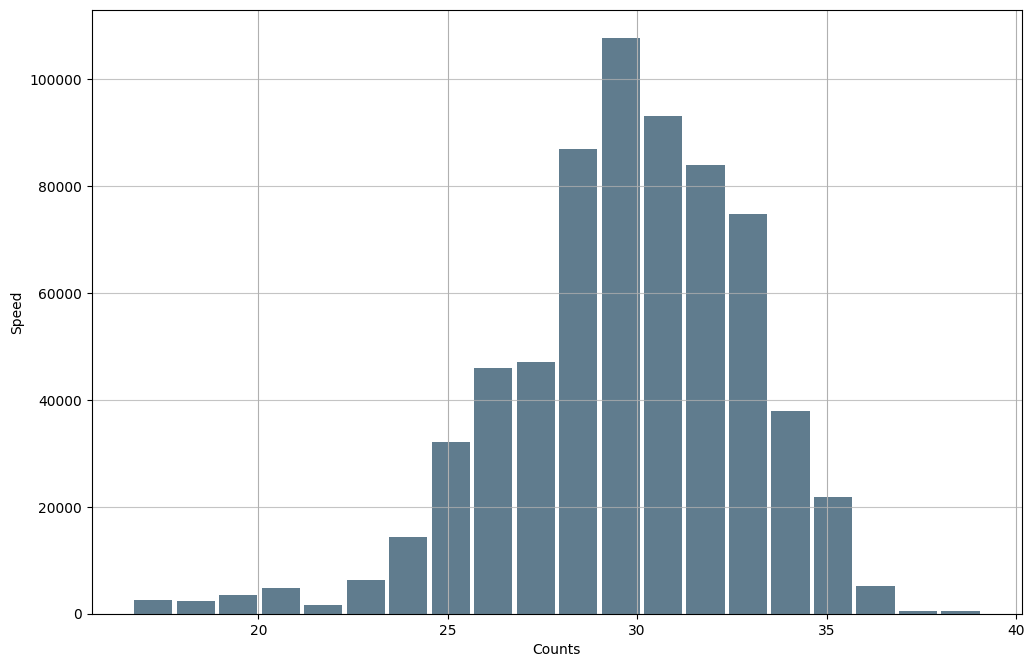

In [5]:
import pandas as pd

size, scale = 1000, 10
commutes = pd.Series(np.array(cv))

commutes.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.xlabel('Counts')
plt.ylabel('Speed')
plt.grid(axis='y', alpha=0.75)

In [10]:
class SimDataset(Dataset):
    def __init__(self, length, i, o):
        self.len = length
        self.i = i
        self.o = o

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.i[idx], self.o[idx]

#PLAN: Model dobi phi, v in IMU, ter phi v nekaj tockah
# v prihodnosti in mora izracunati potreben navor 
# da se doseze tisti kot

prev_data = 100

group_phi_fut = 20
fwd_data = [group_phi_fut*i for i in range(1, 4)]
M_prev_len = 50

all_routes = len(routes)
print(f"{all_routes} routes")
test_count = int(all_routes*0.2)
# test_routes_id = [randrange(all_routes) for _ in range(test_count)]
test_routes_id = [33, 58, 17, 45, 47, 59, 9, 17, 44, 16, 8, 29]

train_routes = [routes[i] for i in range(all_routes) if i not in test_routes_id]
test_routes = [routes[i] for i in range(all_routes) if i in test_routes_id]
#Phi, v, IMU_v, IMU_alpha
groups = [1, 10, 10, 10]
input_length = prev_data//groups[0] + prev_data//groups[1] + 3*prev_data//groups[2] + 3*prev_data//groups[3] + 1 +len(fwd_data)
output_length = len(fwd_data)

mad1 = [0]*3
mad2 = [0]*3
def caddy_dataset(train):
    i_data = []
    o_data = []
    routes = train_routes if train else test_routes
    for route in tqdm(routes):
        for idx in range(prev_data, len(route.v)-fwd_data[-1], 5):
            phi = route.phi[idx-prev_data : idx]/maxAngle
            phi_fut = route.phi[idx : idx + fwd_data[-1]]/maxAngle
            v = route.v[idx-prev_data : idx]/maxSpeed
            M = route.M[idx - M_prev_len : idx]/maxTorque
            M_fut = route.M[idx : idx + fwd_data[-1]]/maxTorque
#             print(phi*maxAngle, end="\n------\n")
#             print(phi_fut*maxAngle, end="\n------\n")
#             print(route.M[idx], M_fut, end="\n------\n")
            
            phi = phi.reshape(-1, groups[0]).mean(axis=1)
            phi_fut = phi_fut.reshape(-1, group_phi_fut).mean(axis=1)
            v = v.reshape(-1, groups[1]).mean(axis=1)
            M = M.reshape(-1, M_prev_len).mean(axis=1)
            M_fut = M_fut.reshape(-1, group_phi_fut).mean(axis=1)
#             print(phi*maxAngle, end="\n------\n")
#             print(phi_fut*maxAngle, end="\n------\n")
            
            IMU_v = [(route.IMU_v[i][idx-prev_data:idx]/maxVDot[i]).reshape(-1, groups[2]).mean(axis=1) for i in range(3)]
            IMU_alpha = [(route.IMU_alpha[i][idx-prev_data:idx]/maxAlphaDot[i]).reshape(-1, groups[3]).mean(axis=1) for i in range(3)]
            for i in range(3):
                mad1[i] = max(max([abs(a) for a in IMU_v[i]]), mad1[i])
            for i in range(3):
                mad2[i] = max(max([abs(a) for a in IMU_alpha[i]]), mad2[i])
            
            o = torch.zeros((output_length,))
            for i in range(output_length):
                o[i] = M_fut[i]
#             print(o)
            data = (phi, v, IMU_v[0], IMU_v[1], IMU_v[2], IMU_alpha[0], IMU_alpha[1], IMU_alpha[2], M, phi_fut)
            data_input = np.concatenate(data)
            i_data.append(data_input)
            o_data.append(o)
#             return []
        print(mad1, mad2)
    return SimDataset(len(i_data), i_data, o_data)


train_set = caddy_dataset(True)
test_set = caddy_dataset(False)

print(len(train_set), len(test_set), test_routes_id)

  0%|          | 0/51 [00:00<?, ?it/s]

62 routes


  2%|▏         | 1/51 [00:00<00:18,  2.65it/s]

[tensor(0.5604), tensor(0.0854), tensor(0.1705)] [tensor(0.1356), tensor(0.0422), tensor(0.1657)]


  4%|▍         | 2/51 [00:00<00:13,  3.52it/s]

[tensor(0.5609), tensor(0.1613), tensor(0.2459)] [tensor(0.1815), tensor(0.0621), tensor(0.1975)]


  6%|▌         | 3/51 [00:01<00:19,  2.45it/s]

[tensor(0.6198), tensor(0.1613), tensor(0.2571)] [tensor(0.3081), tensor(0.0855), tensor(0.2955)]


  8%|▊         | 4/51 [00:01<00:18,  2.54it/s]

[tensor(0.6198), tensor(0.1613), tensor(0.2571)] [tensor(0.3081), tensor(0.1175), tensor(0.4180)]


 10%|▉         | 5/51 [00:01<00:16,  2.82it/s]

[tensor(0.6198), tensor(0.1613), tensor(0.2571)] [tensor(0.3081), tensor(0.1175), tensor(0.4180)]


 12%|█▏        | 6/51 [00:04<00:57,  1.28s/it]

[tensor(0.6198), tensor(0.1967), tensor(0.3354)] [tensor(0.3081), tensor(0.1175), tensor(0.4180)]


 14%|█▎        | 7/51 [00:09<01:39,  2.26s/it]

[tensor(0.6198), tensor(0.1967), tensor(0.3354)] [tensor(0.3147), tensor(0.1175), tensor(0.4308)]


 16%|█▌        | 8/51 [00:10<01:20,  1.88s/it]

[tensor(0.6198), tensor(0.1967), tensor(0.3354)] [tensor(0.3147), tensor(0.1175), tensor(0.4308)]


 20%|█▉        | 10/51 [00:10<00:42,  1.03s/it]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3610), tensor(0.1175), tensor(0.4308)]
[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3610), tensor(0.1175), tensor(0.4308)]


 22%|██▏       | 11/51 [00:11<00:33,  1.21it/s]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3610), tensor(0.1175), tensor(0.4308)]


 24%|██▎       | 12/51 [00:11<00:25,  1.53it/s]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3610), tensor(0.1215), tensor(0.4308)]


 25%|██▌       | 13/51 [00:15<01:09,  1.83s/it]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3610), tensor(0.1215), tensor(0.4308)]


 27%|██▋       | 14/51 [00:19<01:29,  2.41s/it]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3610), tensor(0.1215), tensor(0.4765)]


 29%|██▉       | 15/51 [00:23<01:41,  2.82s/it]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3610), tensor(0.1215), tensor(0.4765)]


 31%|███▏      | 16/51 [00:26<01:41,  2.91s/it]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3610), tensor(0.1215), tensor(0.4765)]


 33%|███▎      | 17/51 [00:27<01:14,  2.21s/it]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3996), tensor(0.1215), tensor(0.4765)]


 35%|███▌      | 18/51 [00:31<01:34,  2.87s/it]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3996), tensor(0.1215), tensor(0.4765)]


 39%|███▉      | 20/51 [00:32<00:50,  1.64s/it]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3996), tensor(0.1215), tensor(0.4765)]
[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3996), tensor(0.1215), tensor(0.4765)]


 43%|████▎     | 22/51 [00:33<00:27,  1.07it/s]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3996), tensor(0.1215), tensor(0.4765)]
[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3996), tensor(0.1215), tensor(0.4765)]


 45%|████▌     | 23/51 [00:33<00:19,  1.40it/s]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3996), tensor(0.1215), tensor(0.4765)]


 47%|████▋     | 24/51 [00:34<00:20,  1.29it/s]

[tensor(0.6343), tensor(0.1967), tensor(0.3354)] [tensor(0.3996), tensor(0.1277), tensor(0.5504)]


 49%|████▉     | 25/51 [00:35<00:19,  1.33it/s]

[tensor(0.6343), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.5504)]


 51%|█████     | 26/51 [00:35<00:18,  1.34it/s]

[tensor(0.6343), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.5504)]


 53%|█████▎    | 27/51 [00:35<00:14,  1.67it/s]

[tensor(0.6343), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.5504)]


 55%|█████▍    | 28/51 [00:36<00:11,  2.07it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.5504)]


 57%|█████▋    | 29/51 [00:36<00:10,  2.10it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.5504)]


 59%|█████▉    | 30/51 [00:36<00:08,  2.47it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.5504)]


 61%|██████    | 31/51 [00:39<00:22,  1.13s/it]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.5664)]


 63%|██████▎   | 32/51 [00:40<00:20,  1.06s/it]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.5664)]


 65%|██████▍   | 33/51 [00:40<00:15,  1.19it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.5664)]


 67%|██████▋   | 34/51 [00:42<00:17,  1.02s/it]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.6338)]


 69%|██████▊   | 35/51 [00:42<00:13,  1.22it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.6338)]


 71%|███████   | 36/51 [00:43<00:12,  1.18it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.6338)]


 73%|███████▎  | 37/51 [00:44<00:11,  1.17it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.6338)]


 75%|███████▍  | 38/51 [00:44<00:09,  1.35it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.6338)]


 76%|███████▋  | 39/51 [00:46<00:12,  1.01s/it]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.6338)]


 80%|████████  | 41/51 [00:48<00:09,  1.01it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.6338)]
[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.6338)]


 82%|████████▏ | 42/51 [00:53<00:18,  2.06s/it]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 84%|████████▍ | 43/51 [00:55<00:15,  1.96s/it]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 86%|████████▋ | 44/51 [00:56<00:11,  1.62s/it]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 90%|█████████ | 46/51 [00:56<00:04,  1.04it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]
[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 92%|█████████▏| 47/51 [00:56<00:02,  1.37it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 94%|█████████▍| 48/51 [00:57<00:02,  1.44it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 98%|█████████▊| 50/51 [00:58<00:00,  1.80it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]
[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


  0%|          | 0/11 [00:00<?, ?it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


  9%|▉         | 1/11 [00:00<00:01,  6.53it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 27%|██▋       | 3/11 [00:00<00:01,  4.14it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]
[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 36%|███▋      | 4/11 [00:01<00:02,  2.81it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 45%|████▌     | 5/11 [00:01<00:02,  2.71it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 55%|█████▍    | 6/11 [00:02<00:01,  2.75it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 64%|██████▎   | 7/11 [00:03<00:02,  1.69it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 73%|███████▎  | 8/11 [00:04<00:02,  1.17it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


 82%|████████▏ | 9/11 [00:05<00:01,  1.14it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1277), tensor(0.8263)]


100%|██████████| 11/11 [00:06<00:00,  1.63it/s]

[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1493), tensor(0.8263)]
[tensor(0.6640), tensor(0.2819), tensor(0.3354)] [tensor(0.5309), tensor(0.1493), tensor(0.8263)]
86609 9797 [33, 58, 17, 45, 47, 59, 9, 17, 44, 16, 8, 29]


In [263]:
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=False)
print(len(train_dataloader))
print(len(test_dataloader))

1353
154


In [265]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_length, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_length),
            nn.Tanh()
        )

        
    def forward(self, x):
        return self.linear_relu_stack(x)
print(input_length)

264


In [266]:
def train_loop(dataloader, model, loss_fn, optimizer, debug):
    size = len(dataloader.dataset)
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if debug:
        loss = loss.item()
        print(f"Train loss: {loss}")
    return loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    print(f"Test  loss: {test_loss} \n")
    return test_loss

model = NeuralNetwork()
for p in model.parameters():
    print(p.shape)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

torch.Size([64, 264])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([32, 64])
torch.Size([32])
torch.Size([3, 32])
torch.Size([3])
23299


epochs = 50
skip = 1
loss_t = []
loss_e = []
for t in range(epochs):
    if t%skip == 0:
        print(f"Epoch {t}")
    loss_t.append(train_loop(train_dataloader, model, loss_fn, optimizer, t%skip==0))
    if t%skip == 0:
        loss_e.append(test_loop(test_dataloader, model, loss_fn))

plt_skip = 5

plt.plot(np.linspace(1, epochs-plt_skip, epochs-plt_skip), loss_t[plt_skip:])
plt.plot(np.linspace(1, epochs-plt_skip, epochs-plt_skip), loss_e[plt_skip:])

tensor([-0.1283, -0.1260, -0.1262], grad_fn=<MulBackward0>)


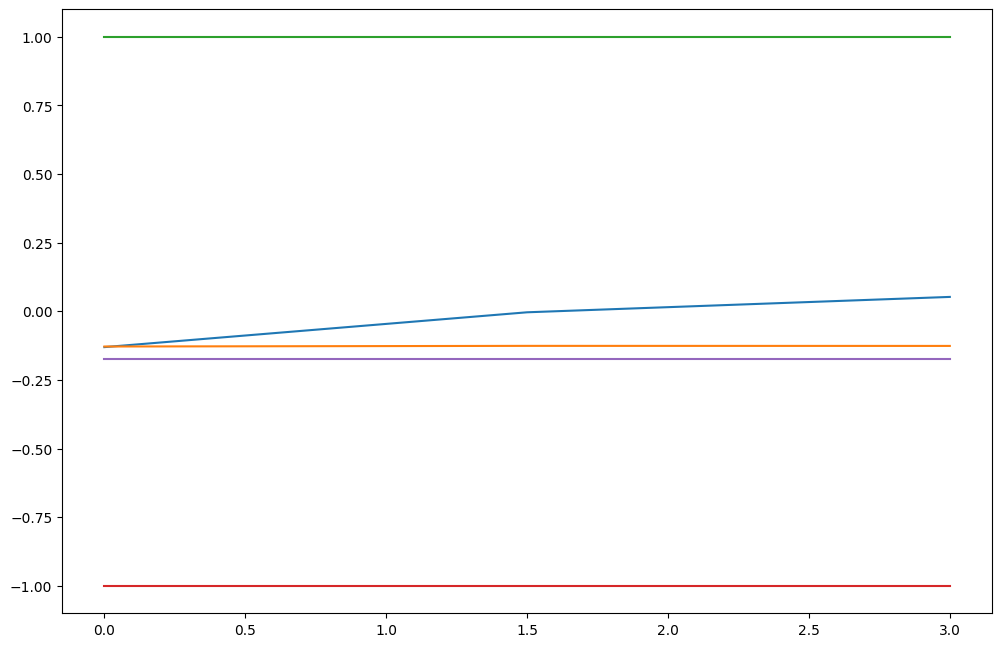

In [279]:
random_sample = test_set[randrange(len(test_set))]
data_input = random_sample[0]
init_M = data_input[-len(fwd_data)-1]
torch_data_input = torch.from_numpy(data_input)
torch_data_output = model(torch_data_input)

print(torch_data_output*maxTorque)

ls_good = [random_sample[1][i]*maxTorque for i in range(output_length)]
ls_pred = [torch_data_output[i]*maxTorque for i in range(output_length)]

plt.plot(np.linspace(0, output_length, output_length), ls_good)
plt.plot(np.linspace(0, output_length, output_length), ls_pred)
plt.plot(np.linspace(0, output_length, output_length), np.ones((output_length,)))
plt.plot(np.linspace(0, output_length, output_length), np.ones((output_length,))*-1)
plt.plot(np.linspace(0, output_length, output_length), np.ones((output_length,))*init_M)

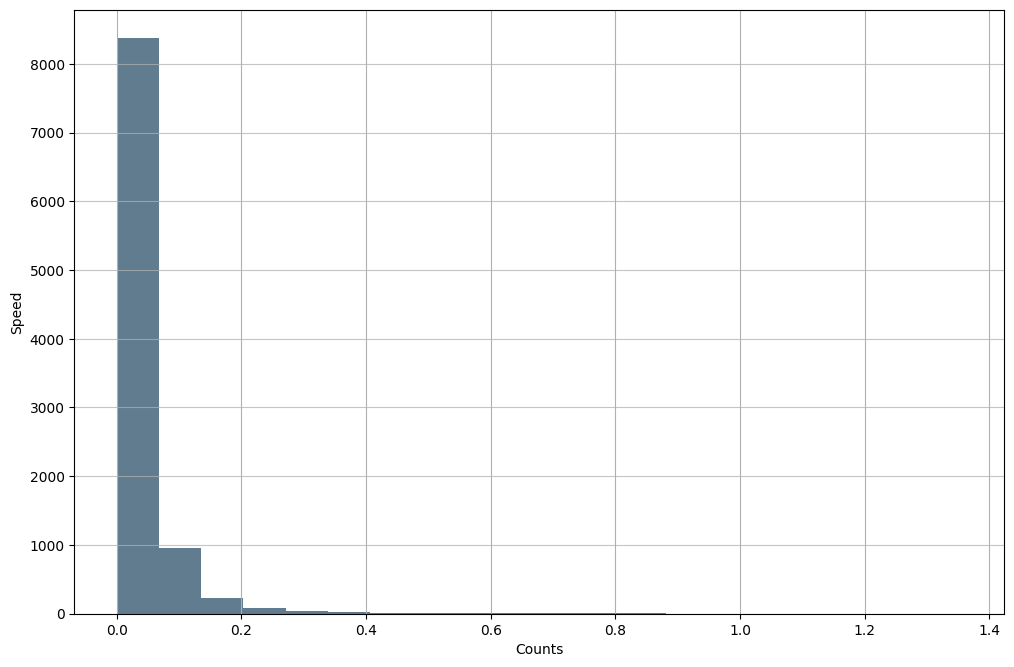

In [282]:
lshape = []
for random_sample in test_set:

    data_input = random_sample[0]
    torch_data_input = torch.from_numpy(data_input)
    torch_data_output = model(torch_data_input)


    ls_good = [random_sample[1][i]*maxTorque for i in range(output_length)]
    ls_pred = [torch_data_output[i]*maxTorque for i in range(output_length)]
    mse = sum([(ls_good[i].item()-ls_pred[i].item())**2 for i in range(output_length)])
    lshape.append(mse)
size, scale = 1000, 20
commutes = pd.Series(np.array(lshape))

commutes.plot.hist(grid=True, bins=20, color='#607c8e')
plt.xlabel('Counts')
plt.ylabel('Speed')
plt.grid(axis='y', alpha=0.75)

In [281]:
good = 0
bad = 0
for random_sample in test_set:

    data_input = random_sample[0]
    init_M = data_input[-len(fwd_data)-1]
    torch_data_input = torch.from_numpy(data_input)
    torch_data_output = model(torch_data_input)


    ls_good = [random_sample[1][i]*maxTorque for i in range(output_length)]
    ls_pred = [torch_data_output[i]*maxTorque for i in range(output_length)]
    if ls_good[0]<init_M and ls_pred[0] < init_M:
        good+=1
    elif ls_good[0]>init_M and ls_pred[0] > init_M:
        good+=1
    else:
        bad+=1
print(good, bad)

6976 2821


In [283]:
torch.save(model, 'model_M.pth')